# Fastai with HuggingFace 🤗Transformers (BERT)


## Libraries Installation


In [1]:
%%bash
pip install -q transformers

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig


The current versions of the fastai and transformers libraries are respectively 1.0.58 and 2.5.1.

In [3]:
!pip install fastai


In [ ]:
!pip install transformers

In [4]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 3.4.0


In [5]:
DATA_ROOT = Path("./dataset") #/ "/kaggle/input/sentiment-analysis-on-movie-reviews"
train = pd.read_csv(DATA_ROOT / 'hateval2019_es_train.csv')
test = pd.read_csv(DATA_ROOT / 'hateval2019_es_dev.csv')
print(train.shape,test.shape)
train.head()

(4500, 5) (500, 5)


,id,text,HS,TR,AG
0,20001,Easyjet quiere duplicar el número de mujeres p...,1,0,0
1,20002,El gobierno debe crear un control estricto de ...,1,0,0
2,20003,Yo veo a mujeres destruidas por acoso laboral ...,0,0,0
3,20004,"— Yo soy respetuoso con los demás, sólamente l...",0,0,0
4,20007,Antonio Caballero y como ser de mal gusto e ig...,0,0,0


## Main transformers classes


In [6]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [48]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

#model_type = 'bert'
#pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [49]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

Print the available values for ``pretrained_model_name`` (shortcut names) corresponding to the ``model_type`` used.

In [ ]:
#model_class.pretrained_model_archive_map.keys()

## Util function

Function to set the seed for generating random numbers.

In [50]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [51]:
seed_all(seed)

## Data pre-processing


### Custom Tokenizer



In [52]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [53]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1374: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,


### Custom Numericalizer


In [54]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

### Custom processor
Now that we have our custom **tokenizer** and **numericalizer**, we can create the custom **processor**. Notice we are passing the ``include_bos = False`` and ``include_eos = False`` options. This is because ``fastai`` adds its own special tokens by default which interferes with the ``[CLS]`` and ``[SEP]`` tokens added by our custom tokenizer.

In [55]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up the Databunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor ``transformer_processor`` and manage correctly the padding.

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [56]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [57]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

There is multible ways to create a DataBunch, in our implementation, we use [the data block API](https://docs.fast.ai/data_block.html#The-data-block-API), which gives more flexibility.

In [58]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols='HS')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

Check batch and tokenizer :

In [59]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> ĠCar ic ach up as ĠðŁĳ ı ðŁ ı ¼ ðŁĳ ı ðŁ ı ¼ ĠPresent a ĠðŁĳ ı ðŁ ı ¼ ðŁĳ ı ðŁ ı ¼ ĠN omb res Ġde ĠðŁĳ ı ðŁ ı ¼ ðŁĳ ı ðŁ ı ¼ ĠTa quer ÃŃ as Ġch idas ðŁĳ ı ðŁ ı ¼ ðŁĳ ı ðŁ ı ¼ ĠPor Ġe j empl o ĠðŁĳ ı ðŁ ı ¼ ðŁĳ ı,0
"<s> ĠðŁ ¤ £ ðŁ ¤ £ Su Ġtier ra Ġti ene Ġun Ġ60 Ġ% Ġapr x Ġ, Ġde ĠÃ ¡ rab es Ġ, Ġarg ent inos Ġ Ġy Ġdem Ã¡s Ġem igrant es Ġ, Ġ........ mas Ġlos Ġes pa Ã± oles Ġque Ġest am os Ġa Ġla Ġpar Ġcon Ġell os Ġ, Ġque Ġr ond am os Ġel Ġ20 Ġ% ĠLa ĠRA ZA ĠBL AN CA ĠEN ĠEXT IN",1
<s> ĠHoy Ġin icia Ġel ĠFestival ĠGast ron Ã³ m ico ĠC uch ara ĠE âĢ Ļ P alo Ġen Ġ@ cc cart agen aco Ġy Ġest Ã¡ Ġes pect acular !! . Ġ# Mexico Ġpa ÃŃs Ġinv it ado Ġde Ġhonor . ĠA Ã±o ĠðŁ ĩ ² ðŁ ĩ ½ - ðŁ ĩ ¨ ðŁ ĩ ´ Ġ# S abe resy Sab ores Ġ@ s abe ress ab ores,0
"<s> ĠAM IG OS ĠCON ĠTOD O ĠEL ĠRESP ET O ĠY ĠCON ĠMAS ĠHUM OR , ĠL ES ĠCOMP ART O ĠEST A ĠPUBLIC ID AD ĠDE ĠT AC OS ĠÃ ģ RA B ES ĠY ĠMAS , ĠU B IC AD O ĠEN ĠCAM INO ĠV IE JO ĠA ĠLA ĠV ENT OS A , ĠDON DE ĠE NC ON TR ARA : ĠT AC OS ĠÃ ģ",0
"<s> ĠA RA BI A ĠSA UD IT A , ĠEM IR AT OS ĠA RA B ES , ĠK U WA IT ĠY ĠDEM Ã ģ S ĠAD IN ER AD OS ĠCON ĠL OS ĠMAS ONES ĠJ UD AS ĠY ĠDEM Ã ģ S ĠDEL ĠM UN DO ĠHERE J E , ĠCA V AND O ĠSU ĠPR OP IA ĠT UM BA ĠSU BS ID I AND",1


Check batch and numericalizer :

In [60]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 200])
tensor([[    0,  1653,   636,  ...,  9357,  2023,     2],
        [    0,  5168,  2808,  ...,     1,     1,     1],
        [    0,  1223,  6527,  ...,     1,     1,     1],
        ...,
        [    0,   287,   118,  ...,     1,     1,     1],
        [    0,  1448,   181,  ...,     1,     1,     1],
        [    0,  8103, 15113,  ...,     1,     1,     1]])


### Custom model
As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a ``tuple`` with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits. 
One way to access them is to create a custom model.

In [61]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels. To do so, you can modify the config instance or either modify like in [Keita Kurita's article](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (Section: *Initializing the Learner*) the ``num_labels`` argument.

In [62]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 3
config.use_bfloat16 = use_fp16
print(config)


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [63]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

## Learner : Custom Optimizer / Custom Metric
In ``pytorch-transformers``, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer.
This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within ``fastai``.
It is worth noting that for reproducing BertAdam specific behavior, you have to set ``correct_bias = False``.


In [64]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

## Discriminative Fine-tuning and Gradual unfreezing (Optional)


In [65]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (d

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

In this case, we can split our model in this way :

In [66]:
# For BERT
#list_layers = [learner.model.transformer.bert.embeddings,
#                learner.model.transformer.bert.encoder.layer[0],
 #               learner.model.transformer.bert.encoder.layer[1],
  #              learner.model.transformer.bert.encoder.layer[2],
   #             learner.model.transformer.bert.encoder.layer[3],
                learner.model.transformer.bert.encoder.layer[4],
                learner.model.transformer.bert.encoder.layer[5],
                learner.model.transformer.bert.encoder.layer[6],
                learner.model.transformer.bert.encoder.layer[7],
                learner.model.transformer.bert.encoder.layer[8],
                learner.model.transformer.bert.encoder.layer[9],
                learner.model.transformer.bert.encoder.layer[10],
                learner.model.transformer.bert.encoder.layer[11],
                learner.model.transformer.bert.pooler]
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

Check groups : 

In [67]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


AttributeError: ignored

Note that I didn't found any document that has studied the influence of **Discriminative Fine-tuning** and **Gradual unfreezing** or even **Slanted Triangular Learning Rates** with transformers. Therefore, using these tools does not guarantee better results. If you found any interesting documents, please let us know in the comment.

## Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [26]:
learner.save('untrain')

In [28]:
seed_all(seed)
learner.load('untrain');

Therefore, we first freeze all the groups but the classifier with :

In [29]:
learner.freeze_to(-1)

We check which layer are trainable.

In [30]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [126, 768]           23,440,896 False     
______________________________________________________________________
Embedding            [126, 768]           393,216    False     
______________________________________________________________________
Embedding            [126, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [126, 768]           1,536      False     
______________________________________________________________________
Dropout              [126, 768]           0          False     
______________________________________________________________________
Linear               [126, 768]           590,592    False     
______________________________________________________________________
Linear               [126, 768]           590,592    False     
_______________________________________

For **Slanted Triangular Learning Rates** you have to use the function ``one_cycle``. For more information please check the fastai documentation [here](https://docs.fast.ai/callbacks.one_cycle.html). 

To use our ``one_cycle`` we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using ``lr_find``.

In [31]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 3.31E-05


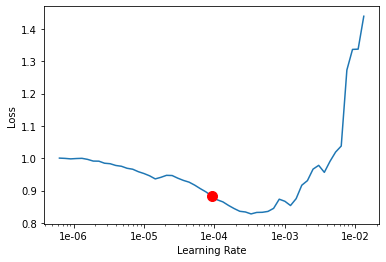

In [32]:
learner.recorder.plot(skip_end=10,suggestion=True)

We will pick a value a bit before the minimum, where the loss still improves. Here 2x10^-3 seems to be a good value.

Next we will use ``fit_one_cycle`` with the chosen learning rate as the maximum learning rate. 

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.666496,0.601760,0.697778,0.302222,00:17


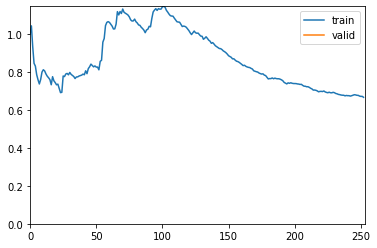

In [33]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [34]:
learner.save('first_cycle')

In [35]:
seed_all(seed)
learner.load('first_cycle');

We then unfreeze the second group of layers and repeat the operations.

In [36]:
learner.freeze_to(-2)

In [37]:
lr = 1e-5

Note here that we use slice to create separate learning rate for each group.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.591536,0.589300,0.706667,0.293333,00:18
1,0.577656,0.587489,0.706667,0.293333,00:20


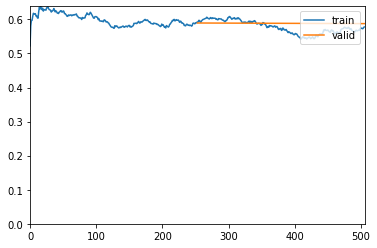

In [38]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [39]:
learner.save('second_cycle')

In [40]:
seed_all(seed)
learner.load('second_cycle');

In [41]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.557273,0.557564,0.724444,0.275556,00:21
1,0.514435,0.494729,0.762222,0.237778,00:23
2,0.484164,0.489948,0.762222,0.237778,00:23


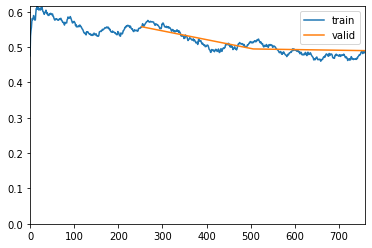

In [42]:
learner.fit_one_cycle(3, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [43]:
learner.save('third_cycle')

In [44]:
seed_all(seed)
learner.load('third_cycle');

Here, we unfreeze all the groups.

In [45]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.451135,0.471555,0.780000,0.220000,00:51
1,0.380869,0.429568,0.804444,0.195556,00:53
2,0.318048,0.462553,0.806667,0.193333,00:54
3,0.212613,0.489978,0.797778,0.202222,00:52


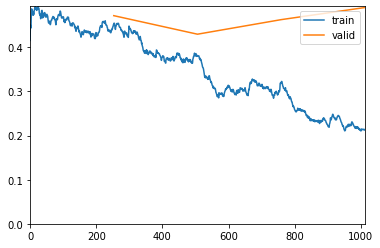

In [46]:
learner.fit_one_cycle(4, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

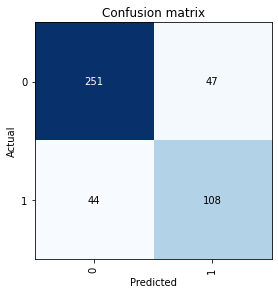

In [47]:
from fastai.version import *
preds, y, losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)
interp.plot_confusion_matrix()

In [ ]:
learner.metrics = [accuracy]


In [ ]:
accuracy

<function fastai.metrics.accuracy>

Now, you can predict examples with:

In [ ]:
#learner.predict('This is the best ...')
learner.predict('@NBCPolitics @MSNBC After 20 days in jail the kids of the illigal refugees must get free. Than nobody should care to them and give them food. The only chance the whole familiy can go home and leave the USA. And sure it must made a supoer big wall to prote')


(Category tensor(0), tensor(0), tensor([9.9669e-01, 3.3087e-03, 2.2233e-06]))

In [ ]:
#learner.predict('This is the worst ...')
learner.predict('Another immigrant sexual assault case being ignored by the MSM. https://t.co/4NUNEDTzNP')


(Category tensor(0), tensor(0), tensor([9.9443e-01, 5.5607e-03, 1.1540e-05]))

## Export Learner
In order to export and load the learner you can do these operations:

In [ ]:
learner.export(file = 'transformer.pkl');

In [ ]:
path = ''
export_learner = load_learner(path, file = 'transformer.pkl')

As mentioned [here](https://docs.fast.ai/basic_train.html#load_learner), you have to be careful that each custom classes - like ``TransformersVocab`` - are first defined before executing ``load_learner``.

In [ ]:
#export_learner.predict('This is the worst ...')
export_learner.predict('Another immigrant sexual assault case being ignored by the MSM. https://t.co/4NUNEDTzNP')


## Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

As specified in Keita Kurita's [article](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/), as the function ``get_preds`` does not return elements in order by default, you will have to resort the elements into their correct order.

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("predictions.csv", index=False)

We check the order.

In [ ]:
test.head()

,id,text,HS,TR,AG
0,18201,I swear I’m getting to places just in the nick...,0,0,0
1,18202,I’m an immigrant — and Trump is right on immig...,0,0,0
2,18203,#IllegalImmigrants #IllegalAliens #ElectoralSy...,1,0,1
3,18204,@DRUDGE_REPORT We have our own invasion issues...,1,0,1
4,18205,Worker Charged With Sexually Molesting Eight C...,0,0,0


In [ ]:
#sample_submission.head()

In [ ]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='predictions.csv')

# References
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* Keita Kurita's article : [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (May 2019)
* Dev Sharma's article : [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Sep 2019)